The goal of this notebook is to investigate:

1. Whether aspirators tend to have more neutrophils in their lungs or not
2. Whether the amount of neutrophils correlates with either lung/throat or lung/gastric similarities

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.rel_abun.clean'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

meta = pd.read_csv(fnmeta, sep='\t', index_col=0)
meta.columns

Index([u' If Yes, specify the symptom score',
       u' If yes, please indicate level', u'% time pH<4', u'% time pH<4:',
       u'A1. Subject ID number:', u'A2. Subject initials:',
       u'A3. What Cohort is the subject enrolled into?',
       u'A4. Aim(s) enrolled in?',
       u'A5.  Date of initial/baseline visit/procedure (MM/DD/YYYY):',
       u'A5a. Date filled out(MM/DD/YYYY):',
       ...
       u'STUDYID', u'STUDY', u'AIM', u'SOURCE', u'PHMII', u'ACIDSUP', u'DATE',
       u'ppi_consolidated', u'mbs_consolidated', u'total_reads'],
      dtype='object', length=958)

In [3]:
neutro_cols = [i for i in meta.columns if 'neutro' in i.lower()]
neutro_cols

['If Yes, what was the percentage of neutrophils',
 'If Yes, what was the percentage of neutrophils?']

In [4]:
newcol = 'neutrophil_consolidated'

def consolidate_neutrophils(row, neutro_cols):
    val = np.nan
    
    # First neutro_col should only have numbers or nans (no strings)
    n0 = row[neutro_cols[0]]
    if not np.isnan(n0):
        val = float(n0)
    
    # Second neutro_col has a few 'Not Done', so the column is strings
    n1 = row[neutro_cols[1]]
    if n1 != "Not Done" and not np.isnan(float(n1)):
        val = float(n1)
        
    return val

meta[newcol] = meta.apply(lambda row: consolidate_neutrophils(row, neutro_cols), axis=1)

# Neutrophils in aspirators vs. non-aspirators

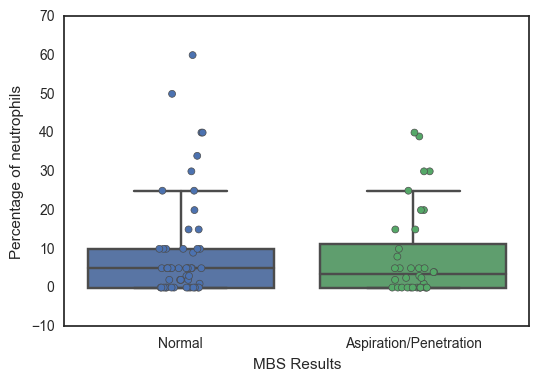

In [5]:
sns.set_style('white')
toplot = meta[['subject_id', 'mbs_consolidated', newcol]].drop_duplicates()
sns.boxplot(data=toplot, x='mbs_consolidated', y=newcol, fliersize=0)
sns.stripplot(data=toplot, x='mbs_consolidated', y=newcol, jitter=True, linewidth=0.5)
plt.xlabel('MBS Results')
plt.ylabel('Percentage of neutrophils')

Nope, they look the exact same... Not hopeful for the JSD correlation, but let's try it anyway

# JSD vs neutrophils

In [6]:
fnjsd = '/Users/claire/github/aspiration-analysis/data/analysis/jsd.txt'

jsd = pd.read_csv(fnjsd, sep='\t').dropna(how='all', axis=1)

## Add neutrophil metadata to JSD (TODO: put this in the JSD code...)
jsd = jsd.query('patient_comp == "within"')
jsd = jsd.join(meta[newcol], on='sample1')
jsd['mbs_consolidated'] = jsd['mbs_consolidated'].fillna('nan')

/Users/claire/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,21,22,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


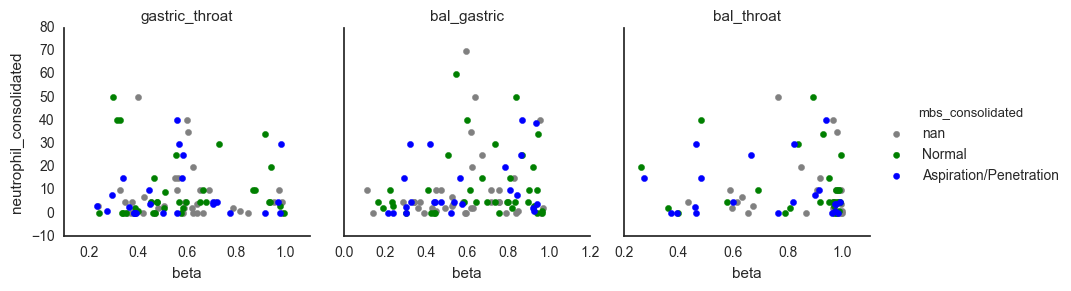

In [7]:
sns.set_style('white')
colors = {'Normal': 'green', 'Aspiration/Penetration': 'blue', 'nan': 'gray'}
sitecomps = ['bal_throat', 'bal_gastric', 'gastric_throat']
g = sns.FacetGrid(
    data=jsd.query('site_comparison == @sitecomps'), 
    col='site_comparison', 
    hue='mbs_consolidated', 
    sharex=False, legend_out=True,
    palette=colors, aspect=1)
g.map(plt.scatter, 'beta', newcol).add_legend().set_titles("{col_name}")

In [38]:
for site in sitecomps:
    tmp = jsd.query('site_comparison == @site').dropna(subset=[newcol, 'beta'])
    r, p = pearsonr(tmp['neutrophil_consolidated'], tmp['beta'])
    print('{}: r = {:.2f}, p = {:.2f}'.format(site, r, p))
    

bal_throat: r = -0.05, p = 0.68
bal_gastric: r = 0.18, p = 0.08
gastric_throat: r = -0.02, p = 0.82


Looks like there's no pattern - one more check though, let's see a different beta diversity measure?

## Unifrac

In [41]:
fnuni = '/Users/claire/github/aspiration-analysis/data/analysis/weighted_unifrac.txt'

uni = pd.read_csv(fnuni, sep='\t').dropna(how='all', axis=1)

## Add neutrophil metadata to JSD (TODO: put this in the JSD code...)
uni = uni.query('patient_comp == "within"')
uni = uni.join(meta[newcol], on='sample1')
uni['mbs_consolidated'] = uni['mbs_consolidated'].fillna('nan')

/Users/claire/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


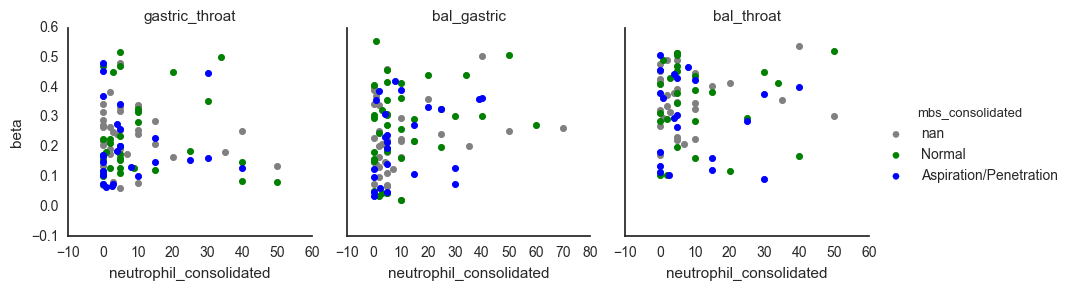

In [42]:
sns.set_style('white')
colors = {'Normal': 'green', 'Aspiration/Penetration': 'blue', 'nan': 'gray'}
sitecomps = ['bal_throat', 'bal_gastric', 'gastric_throat']
g = sns.FacetGrid(
    data=uni.query('site_comparison == @sitecomps'), 
    col='site_comparison', 
    hue='mbs_consolidated', 
    sharex=False, legend_out=True,
    palette=colors, aspect=1)
g.map(plt.scatter, 'beta', newcol).add_legend().set_titles("{col_name}")

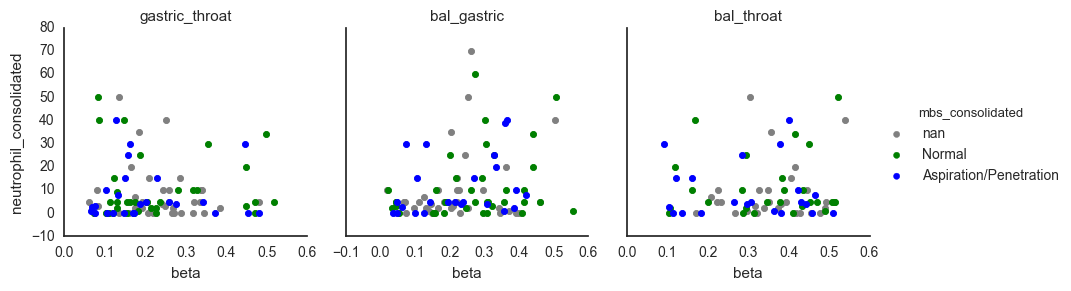

In [43]:
sns.set_style('white')
colors = {'Normal': 'green', 'Aspiration/Penetration': 'blue', 'nan': 'gray'}
sitecomps = ['bal_throat', 'bal_gastric', 'gastric_throat']
g = sns.FacetGrid(
    data=uni.query('site_comparison == @sitecomps'), 
    col='site_comparison', 
    hue='mbs_consolidated', 
    sharex=False, legend_out=True,
    palette=colors, aspect=1)
g.map(plt.scatter, 'beta', newcol).add_legend().set_titles("{col_name}")